# CIFAR10 Resnet版

## ライブラリインポート

In [ ]:
# PyTooch関連ライブラリインポート

import torch
import torchvision
import torch.nn as nn
from torch import optim
import torch.nn.init as init
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

In [2]:
# バージョン確認

print(torch.__version__)
print(torchvision.__version__)

1.7.0+cu101
0.8.1+cu101


In [ ]:
# それ以外のライブラリインポート

%matplotlib inline
import numpy as np
!pip install japanize_matplotlib | tail -n 1
import matplotlib.pyplot as plt
import japanize_matplotlib

## データ読み込み

In [ ]:
# transformの定義

# 検証データ用 : 正規化のみ実施
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 訓練データ用: 正規化に追加で反転とRandomErasingを実施
transform_train = transforms.Compose([
  transforms.RandomHorizontalFlip(p=0.5), 
  transforms.ToTensor(),
  transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]), 
  transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])


In [ ]:
# データディレクトリ
data_dir = './cifar10'

# 学習データ読み込み
batch_size = 100

# DatasetとDataLoaderの定義

# 訓練用
train_data = datasets.CIFAR10(root = data_dir, train = True, download = True, 
  transform=transform_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# 検証用
test_data = datasets.CIFAR10(root=data_dir, train = False, download = False, 
  transform=transform)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


## GPUのチェック

In [111]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 学習済みモデルの読み込み

In [ ]:
model_ft = models.resnet50(pretrained = True)
# model_ft = models.resnet18(pretrained = True)
# model_ft = models.resnet152(pretrained = True)
# model_ft = models.vgg19_bn(pretrained = True)

# 最終ノードの出力を10に変更する
model_ft.fc = nn.Linear(model_ft.fc.in_features, 10)

# resnetの時は下に修正しないとエラーになる
#model_ft.fc = nn.Linear(4096, 10)

# GPUの利用
net = model_ft.to(device)

# 損失関数に交差エントロピーを利用
criterion = nn.CrossEntropyLoss()

# 最適化に関しては、いくつかのパターンを調べた結果、下記が一番結果がよかった
optimizer = optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

In [ ]:
# モデルの概要表示をしたい場合

# net

In [ ]:
# モデルのサマリー表示をしたい場合

#from torchsummary import summary
#summary(net,(3,32,32))

## 学習

In [ ]:
# 記録用リストの初期化

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

nb_epoch = 20
#nb_epoch = 10

## 学習メインループ

In [117]:
for i in range(nb_epoch):
  train_loss = 0
  train_acc = 0
  val_loss = 0
  val_acc = 0

  #学習
  net.train()

  for images, labels in train_loader:

    #勾配の初期化(ループの頭でやる必要あり)
    optimizer.zero_grad()

    # 訓練データの準備
    images = images.to(device)
    labels = labels.to(device)

    # 順伝搬計算
    outputs = net(images)

    # 誤差計算
    loss = criterion(outputs, labels)
    train_loss += loss.item()

    # 学習
    loss.backward()
    optimizer.step()

    #予測値算出
    predicted = outputs.max(1)[1]

    #正解件数算出
    train_acc += (predicted == labels).sum()

  # 訓練データに対する損失と精度の計算
  avg_train_loss = train_loss / len(train_loader.dataset)
  avg_train_acc = train_acc / len(train_loader.dataset)

  #評価
  net.eval()
  with torch.no_grad():

    for images, labels in test_loader:

      # テストデータの準備
      images = images.to(device)
      labels = labels.to(device)

      # 順伝搬計算
      outputs = net(images)

      # 誤差計算
      loss = criterion(outputs, labels)
      val_loss += loss.item()

      #予測値算出
      predicted = outputs.max(1)[1]

      #正解件数算出
      val_acc += (predicted == labels).sum()

    # 検証データに対する損失と精度の計算
    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)

  print (f'Epoch [{(i+1)}/{nb_epoch}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
  train_loss_list.append(avg_train_loss)
  train_acc_list.append(avg_train_acc)
  val_loss_list.append(avg_val_loss)
  val_acc_list.append(avg_val_acc)


Epoch [1/20], loss: 0.01219 acc: 0.57030 val_loss: 0.00720, val_acc: 0.74880
Epoch [2/20], loss: 0.00765 acc: 0.73106 val_loss: 0.00588, val_acc: 0.79330
Epoch [3/20], loss: 0.00641 acc: 0.77696 val_loss: 0.00527, val_acc: 0.81850
Epoch [4/20], loss: 0.00557 acc: 0.80516 val_loss: 0.00486, val_acc: 0.83420
Epoch [5/20], loss: 0.00496 acc: 0.82710 val_loss: 0.00472, val_acc: 0.84200
Epoch [6/20], loss: 0.00448 acc: 0.84486 val_loss: 0.00453, val_acc: 0.84300
Epoch [7/20], loss: 0.00415 acc: 0.85530 val_loss: 0.00446, val_acc: 0.84880
Epoch [8/20], loss: 0.00377 acc: 0.86842 val_loss: 0.00446, val_acc: 0.85550
Epoch [9/20], loss: 0.00349 acc: 0.87958 val_loss: 0.00447, val_acc: 0.85280
Epoch [10/20], loss: 0.00320 acc: 0.89036 val_loss: 0.00458, val_acc: 0.85230
Epoch [11/20], loss: 0.00295 acc: 0.89884 val_loss: 0.00459, val_acc: 0.85860
Epoch [12/20], loss: 0.00277 acc: 0.90416 val_loss: 0.00463, val_acc: 0.85810
Epoch [13/20], loss: 0.00263 acc: 0.90986 val_loss: 0.00453, val_acc: 0.8

In [ ]:
#val_loss_lists = {}
#val_acc_lists = {}

In [ ]:
ind = 'resnet50'
val_loss_lists[ind] = val_loss_list
val_acc_lists[ind] = val_acc_list

In [ ]:
# print(val_loss_lists.keys())

In [ ]:
#ind = 'resnet50'
#val_loss_lists[ind] = val_loss_lists['hf_re']
#val_acc_lists[ind] = val_acc_lists['hf_re']

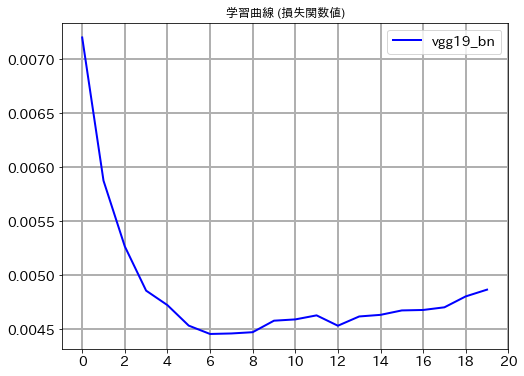

In [122]:
# 学習曲線 (損失関数値)
plt.figure(figsize=(8,6))
plt.plot(val_loss_list,label=ind, lw=2, c='b')
plt.title('学習曲線 (損失関数値)')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.xticks(np.arange(0, 21, 2))
plt.show()

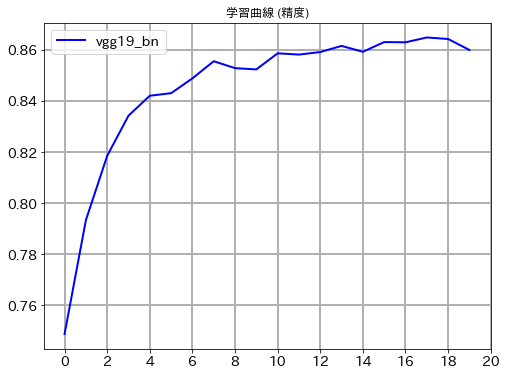

In [123]:
# 学習曲線 (精度)
plt.figure(figsize=(8,6))
plt.plot(val_acc_list,label=ind, lw=2, c='b')
plt.title('学習曲線 (精度)')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.xticks(np.arange(0, 21, 2))
plt.show()

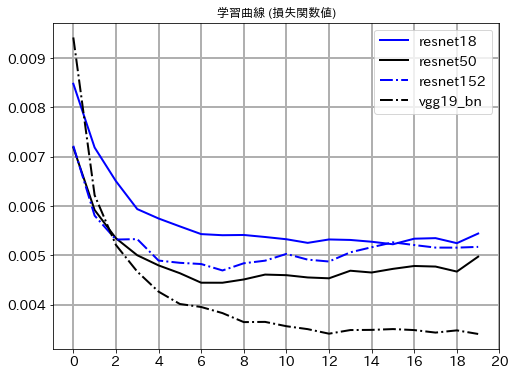

In [120]:
# 学習曲線 (損失関数値)
plt.figure(figsize=(8,6))
plt.plot(val_loss_lists['resnet18'],label='resnet18', lw=2, c='b')
plt.plot(val_loss_lists['resnet50'],label='resnet50', lw=2, c='k')
plt.plot(val_loss_lists['resnet152'],label='resnet152', lw=2, c='b', linestyle = "-.")
plt.plot(val_loss_lists['vgg19_bn'],label='vgg19_bn', lw=2, c='k', linestyle = "-.")
plt.title('学習曲線 (損失関数値)')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.xticks(np.arange(0, 21, 2))
plt.show()

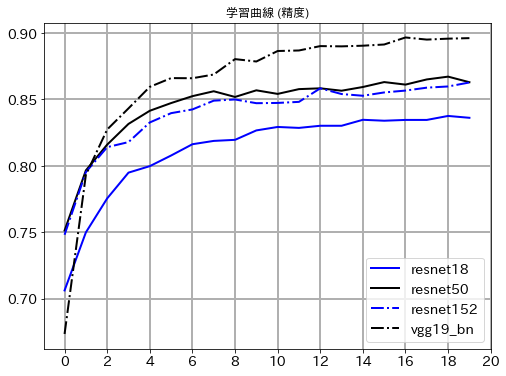

In [124]:
# 学習曲線 (精度)
plt.figure(figsize=(8,6))
plt.plot(val_acc_lists['resnet18'],label='resnet18', lw=2, c='b')
plt.plot(val_acc_lists['resnet50'],label='resnet50', lw=2, c='k')
plt.plot(val_acc_lists['resnet152'],label='resnet152', lw=2, c='b', linestyle = "-.")
plt.plot(val_acc_lists['vgg19_bn'],label='vgg19_bn', lw=2, c='k', linestyle = "-.")
plt.title('学習曲線 (精度)')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.xticks(np.arange(0, 21, 2))
plt.show()

## モデルのエクスポート (Watson ML用)

In [125]:
model_fn = 'cifar10-pytorch-resnet50.onnx'
model_gz = 'cifar10-pytorch-resnet50.gz'

# モデルのエクスポート
dummy_input = torch.randn((1, 3, 32, 32)).to(device)
torch.onnx.export(net, dummy_input, model_fn, keep_initializers_as_inputs=True, verbose=False)

# ｇｚに圧縮
!tar czvf $model_gz $model_fn
!ls -l

cifar10-pytorch-resnet50.onnx
total 177184
drwxr-xr-x 3 root root     4096 Jan 13 03:48 cifar10
-rw-r--r-- 1 root root 87401988 Jan 13 07:19 cifar10-pytorch-resnet50.gz
-rw-r--r-- 1 root root 94022117 Jan 13 07:19 cifar10-pytorch-resnet50.onnx
drwxr-xr-x 1 root root     4096 Jan  6 18:10 sample_data


In [126]:
# gzファイルをPCにダウンロード

from google.colab import files
files.download(model_gz) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>